# **Project Name: Image Segmentation Model**
* We’ll use U-Net, a popular architecture for image segmentation tasks. You can use any dataset of your choice (like Oxford-IIIT Pet Dataset). Below is a basic implementation using Keras.

**Import Liabraries**

In [14]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import cv2
from tensorflow.keras import layers, models

# **Dataset Generation**

100%|██████████| 100/100 [00:00<00:00, 916.48it/s]


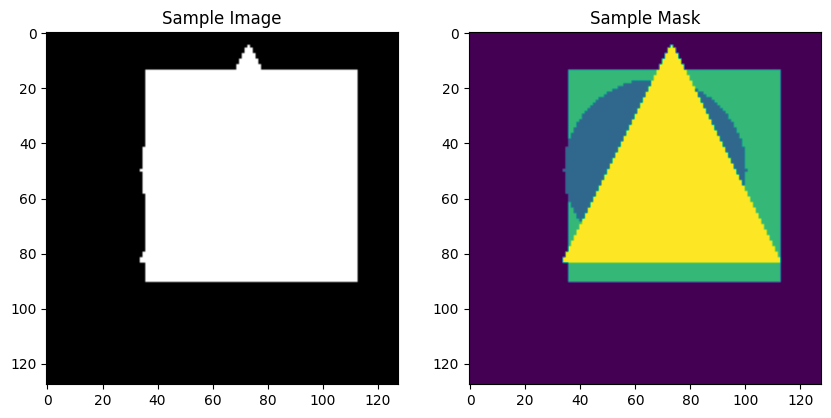

In [1]:


# Parameters for dataset generation
num_images = 100  # Number of images to generate
image_size = 128  # Size of each image (128x128 pixels)
shapes = ['circle', 'square', 'triangle']  # Shapes to include in the dataset

# Directory to save images and masks
image_dir = './synthetic_images/'
mask_dir = './synthetic_masks/'

# Create directories if they don't exist
os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

def draw_shape(image, mask, shape, label):
    """Draw a specific shape on the image and mask."""
    # Random position and size
    center = (np.random.randint(30, 100), np.random.randint(30, 100))
    size = np.random.randint(20, 40)

    if shape == 'circle':
        cv2.circle(image, center, size, (255, 255, 255), -1)
        cv2.circle(mask, center, size, label, -1)

    elif shape == 'square':
        top_left = (center[0] - size, center[1] - size)
        bottom_right = (center[0] + size, center[1] + size)
        cv2.rectangle(image, top_left, bottom_right, (255, 255, 255), -1)
        cv2.rectangle(mask, top_left, bottom_right, label, -1)

    elif shape == 'triangle':
        pts = np.array([[center[0], center[1] - size],
                        [center[0] - size, center[1] + size],
                        [center[0] + size, center[1] + size]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(image, [pts], (255, 255, 255))
        cv2.fillPoly(mask, [pts], label)

def generate_image_and_mask():
    """Generate a synthetic image and corresponding mask."""
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    mask = np.zeros((image_size, image_size), dtype=np.uint8)

    # Randomly select shapes to draw
    num_shapes = np.random.randint(1, 4)  # Random number of shapes per image
    for i in range(num_shapes):
        shape = np.random.choice(shapes)
        label = shapes.index(shape) + 1  # Label for the mask
        draw_shape(image, mask, shape, label)

    return image, mask

# Generate the dataset
for i in tqdm(range(num_images)):
    image, mask = generate_image_and_mask()

    # Save image and mask
    cv2.imwrite(os.path.join(image_dir, f'image_{i}.png'), image)
    cv2.imwrite(os.path.join(mask_dir, f'mask_{i}.png'), mask)

# Display a sample image and its mask
sample_image = cv2.imread(os.path.join(image_dir, 'image_0.png'))
sample_mask = cv2.imread(os.path.join(mask_dir, 'mask_0.png'), 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Sample Image')
plt.imshow(sample_image)

plt.subplot(1, 2, 2)
plt.title('Sample Mask')
plt.imshow(sample_mask)
plt.show()


**Dataset Preparation**

In [3]:
# Load your dataset
image_dir = './synthetic_images/'
mask_dir = './synthetic_masks/'

X = []  # List to store input images
Y = []  # List to store segmented masks

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        # Load image
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        X.append(img)

        # Load corresponding mask
        mask_path = os.path.join(mask_dir, filename.replace('image', 'mask'))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        Y.append(mask)

# Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Data augmentation (optional)
data_gen_args = dict(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

train_image_generator = image_datagen.flow(X_train, Y_train, batch_size=16)
val_image_generator = mask_datagen.flow(X_val, Y_val, batch_size=16)

**U-Net Model Development**

In [6]:
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bridge
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Expansive Path
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.concatenate([up4, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize and train the model
model = unet_model()
model.fit(train_image_generator, validation_data=val_image_generator, epochs=25)


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 101s 16s/step - accuracy: 0.5164 - loss: 2.6237 - val_accuracy: 0.7509 - val_loss: 7.5276
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 130s 17s/step - accuracy: 0.7309 - loss: 8.6779 - val_accuracy: 0.7509 - val_loss: 7.3194
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 140s 16s/step - accuracy: 0.7162 - loss: 8.8979 - val_accuracy: 0.7509 - val_loss: 7.3187
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 17s/step - accuracy: 0.7199 - loss: 9.1869 - val_accuracy: 0.7509 - val_loss: 7.3187
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.7319 - loss: 8.7262 - val_accuracy: 0.7509 - val_loss: 7.3187
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 17s/step - accuracy: 0.7218 - loss: 8.8249 - val_accuracy: 0.7509 - val_loss: 7.3187
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 139s 16s/step - accuracy: 0.7093 - loss: 9.2917 - val_accuracy: 0.7509 - val_loss: 7.3187
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 17s/step - accuracy: 0.7242 - loss: 8.5763 - val_accuracy: 0.7509 - val_loss: 7.3

**Evaluation (IoU)**

In [11]:
import tensorflow as tf

def iou_score(y_true, y_pred):
    # Reshape y_true to add a channel dimension if necessary
    if tf.rank(y_true) == 3:  # Check if y_true has 3 dimensions (no channel)
        y_true = tf.expand_dims(y_true, axis=-1)  # Add channel dimension

    # Ensure y_pred has the correct shape
    # y_pred = tf.squeeze(y_pred, axis=-1)  # Remove the channel dimension if it's size 1 #Commented out this line to avoid shape mismatch

    # Cast y_true to the same type as y_pred (float32)
    y_true = tf.cast(y_true, y_pred.dtype)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

# Evaluate on the validation set
y_pred = model.predict(X_val)
iou = iou_score(Y_val, y_pred)
print(f"Intersection over Union (IoU): {iou}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Intersection over Union (IoU): 0.0


**Visualization**

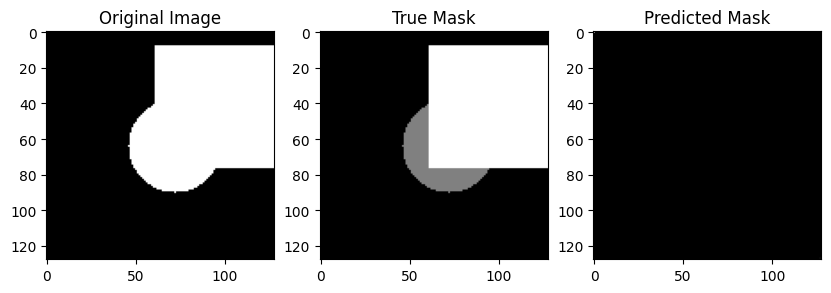

In [12]:
import matplotlib.pyplot as plt

# Visualize original image, true mask, and predicted mask
index = 5  # Example index

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_val[index])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(Y_val[index].squeeze(), cmap='gray')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(y_pred[index].squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()
